In [1]:
import cv2
import glob
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

In [ ]:
# checkerboard square size
square_size_mm = 30

image_files = sorted(glob.glob('calibration-data/cam1-img/*.jpg'))

image_probe = cv2.imread(image_files[0])
image_h, image_w = image_probe.shape[:2]

# checkerboard's size is 8x6 (9x7 squares)
pattern_points = np.zeros((8 * 6, 3), np.float32)
pattern_points[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
# pattern_points *= square_size_mm

# arrays to store object points and image points from all the images
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane

# images to visualization (with detected corners)
images = []

# corner subpixel criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def processImage(fname):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    if found:
        obj_points.append(pattern_points)
        
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        img_points.append(corners)
        
        cv2.drawChessboardCorners(img, (8, 6), corners2, found)
        images.append(img)
        cv2.waitKey(10)
    else:
        print("Couldn't detect the corners of {}".format(fname))


for fname in image_files:
    processImage(fname)
    
# plot images with detected corners
images_cols = 3
images_rows = ceil(len(images) // images_cols)

fig, axes = plt.subplots(images_rows, images_cols, figsize=(50, 50), constrained_layout=True)
[axis.set_axis_off() for axis in axes.ravel()]
                   
for idx, img in enumerate([images[i] for i in [0, 8, 9, 10, 11]]):
    axes[idx % images_rows][idx // images_rows].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

Couldn't detect the corners of calibration-data/cam1-img/cam1-00000001.jpg
Couldn't detect the corners of calibration-data/cam1-img/cam1-00000003.jpg
Couldn't detect the corners of calibration-data/cam1-img/cam1-00000004.jpg
Couldn't detect the corners of calibration-data/cam1-img/cam1-00000006.jpg


In [39]:
obj_points_ = [obj_points[index] for index in [0, 2, 3, 5, 8, 11]]
img_points_ = [img_points[index] for index in [0, 2, 3, 5, 8, 11]]

reproj_err, K, D, rvecs, tvecs = cv2.calibrateCamera(obj_points_, img_points_, (image_w, image_h), None, None)

print("Intrinsic camera parametes:\n {}\n".format(K))
print("Reprojection error (pixels): {}\n".format(reproj_err))
print("Distortion coefficients:\n", D.ravel())

Intrinsic camera parametes:
 [[509.49464727   0.         323.40975239]
 [  0.         509.08364758 220.34557703]
 [  0.           0.           1.        ]]

Reprojection error (pixels): 4.362893407188823

Distortion coefficients:
 [-4.32547122e+00  1.26242222e+02  7.04408946e-02 -3.06438085e-03
 -8.75104424e+02]


- The focal lengths (in X and Y axes) are `~778` and `~725`.

- The image plane's origin is at ~ `(317.8, 240.1)`.

- Intrinsic error `≈ 4.25`.

In [18]:
mean_error = 0
tot_error = 0

for i in range(len(obj_points[:4])):
    img_points2, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], K, D)
    error = float(cv2.norm(img_points[i], img_points2, cv2.NORM_L2) / len(img_points2))
    tot_error += error
    
print ("total error: {}".format(tot_error / len(obj_points)))

total error: 0.14256524885071276


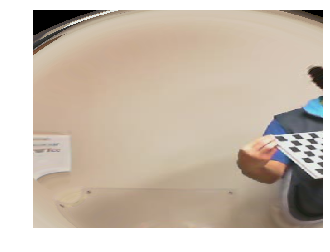

In [19]:
img = cv2.imread(image_files[11])
h, w = img.shape[:2]

K_, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 1, (w,h))

dst = cv2.undistort(img, K, D, None, K_)

plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

total error: 0.5439917049743362
